# HEAPO: Technical Validation
Refer to the "Technical Validation" section in the dataset description paper for details:  
1. Comparison of 15-Min Load Profiles Aggregated to Daily Data vs. Original Daily Readings
2. Analysis of Temperature Variations Across Different Weather Stations

### Imports
**Note:** Before running the script, ensure that `data_path` is set to the correct location of the stored data.

In [6]:
# ----------------------
# IMPORT OTHER PACKAGES 
# ----------------------
import os 
import sys
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
plt.rcParams["font.family"] = "sans-serif"
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# ----------------------
# IMPORT HEAPO SCRIPTS
# ----------------------

# either run script heapo.py inside the src folder
# folder_path = os.path.dirname(os.getcwd())+'/src/'
# %run -i {folder_path + 'heapo.py'}

# or import heapo as a package - RECOMMENDED because Visual Studio Code then recognizes the package
folder_path = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(0, folder_path)
sys.path.insert(0, folder_path + '/heapo/src')
from heapo import *

# ---------------------------------------
# DEFINE PATH TO WHERE THE DATA IS STORED
# ---------------------------------------

# NOTE: if data is stored under /data/ within this repository --> set data_path = None 
data_path = None

# otherwise please provide the absolute path to the HEAPO dataset including the last slash
# data_path = '/Users/user/path/to/heapo_data/'

# ---------------------------------------
# CREATE HEAPO OBJECT
# ---------------------------------------

# create HEAPO object
heapo = HEAPO(data_path=data_path, use_local_time=False, suppress_warning=False)

### Aggregate 15-min Load Profiles to Daily Data for Comparison
**NOTE:** The following execution is rather slow, as it was not optimized for speed. 

In [7]:
# get only control group households 
df_meta = heapo.get_meta_data_overview()
df_meta = df_meta[(df_meta['SmartMeterData_Available_15min'] == True) & (df_meta['SmartMeterData_Available_Daily'] == True)] # (df_meta['Group'] == 'control') 
df_meta.reset_index(inplace=True, drop=True)
df_meta = df_meta.drop(columns=['Group', 'Weather_ID', 'Protocols_Available', 'Protocols_HasMultipleVisits', 'Protocols_ReportIDs', 'MetaData_Available', 'SmartMeterData_Available_15min', 'SmartMeterData_Available_Daily', 'SmartMeterData_Available_Monthly'])

# only use 10 households for debugging (uncomment, if you want to use all as done in the paper)
# df_meta = df_meta.iloc[:10]

# get all households
hhs = df_meta['Household_ID'].values 

# create one data frame to store all ddaily data
df_all = pd.DataFrame(columns=['Household_ID', 'Timestamp', 'kWh_received_Total_15min', 'kWh_received_Total_daily'])

# loop over all households and get their 15-min data, then aggregate it
for idx, hh in tqdm(enumerate(hhs), total=len(hhs)):
    
    # get 15-min data and aggregate to daily
    df = heapo.load_smart_meter_data(hh, resolution='15min')
    df = heapo.change_resolution(df, '1D', timestamp_column='Timestamp', add_missing_dates=False, inplace=True, skipna=False)[['Household_ID', 'Timestamp', 'kWh_received_Total']]
    df['Timestamp'] = df['Timestamp'].dt.date
    df = df.rename(columns={'kWh_received_Total': 'kWh_received_Total_15min'})
    df['kWh_received_Total_15min'] = df['kWh_received_Total_15min'].round(2)

    # load daily data
    df_daily = heapo.load_smart_meter_data(hh, resolution='daily')
    df_daily = df_daily[['Household_ID', 'Timestamp', 'kWh_received_Total']]
    df_daily['Timestamp'] = df_daily['Timestamp'].dt.date
    df_daily = df_daily.rename(columns={'kWh_received_Total': 'kWh_received_Total_daily'})
    
    # fuse both and drop NaNs
    df = df.merge(df_daily, on=['Household_ID', 'Timestamp'], how='outer')
    df = df.dropna()
    df = df.sort_values('Timestamp')
    df = df.reset_index(drop=True)
    df['Household_ID'] = df['Household_ID'].astype(int)

    # only consider households with at least 10 days of overlapping data 
    if len(df) < 10:
        continue

    # append to all data
    if idx == 0:
        df_all = df
    else:
        df_all = pd.concat([df_all, df], axis=0)

display(df_all)
hhs = df_all['Household_ID'].unique()
print('Number of households:', len(hhs))

100%|██████████| 1298/1298 [05:11<00:00,  4.17it/s]


,Household_ID,Timestamp,kWh_received_Total_15min,kWh_received_Total_daily
0,1060,2022-05-26,18.18,18.39
1,1060,2022-05-27,16.94,16.91
2,1060,2022-05-28,12.67,11.65
3,1060,2022-05-29,16.71,16.56
4,1060,2022-05-30,17.89,18.83
...,...,...,...,...
360,9981041,2024-02-23,39.68,39.53
361,9981041,2024-02-24,38.35,38.09
362,9981041,2024-02-25,35.10,35.05
363,9981041,2024-02-26,33.13,34.21


Number of households: 866


### Inspect Exemplary Data

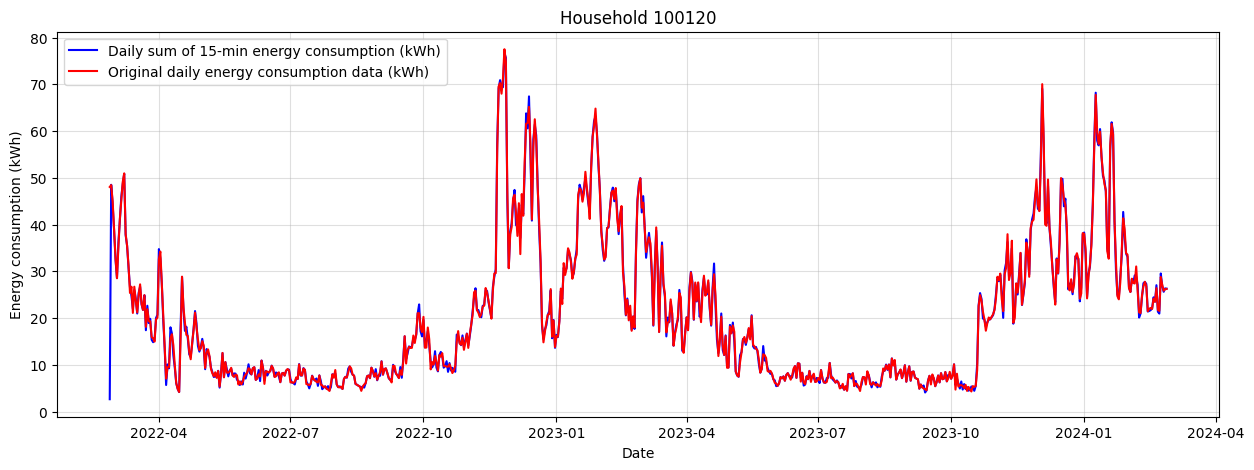

In [8]:
# choose a household to inspect
hh = hhs[4] # 1060
df = df_all[df_all['Household_ID'] == hh]

# plot time series data
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df.plot(ax=ax, x='Timestamp', y='kWh_received_Total_15min', kind='line', color='blue', label='Daily sum of 15-min energy consumption (kWh)')
df.plot(ax=ax, x='Timestamp', y='kWh_received_Total_daily', kind='line', color='red', label='Original daily energy consumption data (kWh)')
ax.set_xlabel('Date')
ax.set_ylabel('Energy consumption (kWh)')
plt.title(f'Household {hh}')
plt.grid(alpha=0.4)
plt.show()

### Calculate Error Metrics

In [9]:
def smape(A, F):
    with np.errstate(divide='ignore', invalid='ignore'):
        tmp = 2 * np.abs(F-A) / (np.abs(A) + np.abs(F))
    tmp[np.isnan(tmp)] = 0
    return np.sum(tmp) / len(tmp) * 100

# calculate scores
df_scores = df_all.groupby('Household_ID').agg(list).reset_index()
df_scores.drop(columns=['Timestamp'], inplace=True)
df_scores['kWh_received_Total_15min'] = df_scores['kWh_received_Total_15min'].apply(lambda x: np.array(x))
df_scores['kWh_received_Total_daily'] = df_scores['kWh_received_Total_daily'].apply(lambda x: np.array(x))
df_scores['R2'] =  df_scores.apply(lambda row: r2_score(row['kWh_received_Total_15min'], row['kWh_received_Total_daily']), axis=1)
df_scores['MSE'] =  df_scores.apply(lambda row: mean_squared_error(row['kWh_received_Total_15min'], row['kWh_received_Total_daily']), axis=1)
df_scores['RMSE'] =  df_scores.apply(lambda row: np.sqrt(row['MSE']), axis=1)
df_scores['MAE'] =  df_scores.apply(lambda row: mean_absolute_error(row['kWh_received_Total_15min'], row['kWh_received_Total_daily']), axis=1)
df_scores['MdAE'] = df_scores.apply(lambda row: np.median(np.abs(row['kWh_received_Total_15min'] - row['kWh_received_Total_daily'])), axis=1)
df_scores['MAPE'] = df_scores.apply(lambda row: mean_absolute_percentage_error(row['kWh_received_Total_15min'], row['kWh_received_Total_daily']), axis=1)*100.0
df_scores['SMAPE'] = df_scores.apply(lambda row: smape(row['kWh_received_Total_15min'], row['kWh_received_Total_daily']), axis=1)
df_scores.drop(columns=['kWh_received_Total_15min', 'kWh_received_Total_daily'], inplace=True)
df_scores = df_scores.sort_values('RMSE')
df_scores.reset_index(drop=True, inplace=True)

display(df_scores)

# now aggregate to mean and std
df_scores_agg = df_scores.drop(columns=['Household_ID']).agg(['mean', 'std']).T
df_scores_agg = df_scores_agg.round(2)
df_scores_agg = df_scores_agg.reset_index()
df_scores_agg = df_scores_agg.rename(columns={'index': 'Metric'})
display(df_scores_agg)

,Household_ID,R2,MSE,RMSE,MAE,MdAE,MAPE,SMAPE
0,101776,0.999664,0.020223,0.142207,0.052497,0.010,1.270608e+14,4.292021
1,991071,0.999485,0.050002,0.223612,0.111473,0.030,2.284780e+00,2.324106
2,848510,0.998124,0.059546,0.244020,0.140453,0.040,1.204869e+00,1.201350
3,737105,0.967608,0.072637,0.269512,0.075148,0.020,6.807275e+00,1.599781
4,661119,0.998806,0.096964,0.311391,0.116000,0.030,4.296663e+00,2.590173
...,...,...,...,...,...,...,...,...
861,461132,-1110.480128,170.589849,13.061005,11.568451,11.125,2.575062e+02,109.288500
862,118985,-44.698892,252.936062,15.903964,9.456284,3.575,1.040563e+02,54.160544
863,1191021,0.852604,260.523811,16.140750,4.212481,1.050,5.163159e+01,8.614959
864,468312,0.765209,345.856062,18.597206,8.901773,1.325,3.428149e+01,14.982800


,Metric,mean,std
0,R2,-3.900000e-01,3.780000e+01
1,MSE,1.044000e+01,7.265000e+01
2,RMSE,2.220000e+00,2.350000e+00
3,MAE,1.000000e+00,1.500000e+00
4,MdAE,4.700000e-01,1.190000e+00
5,MAPE,2.027588e+13,3.180788e+14
6,SMAPE,4.860000e+00,8.300000e+00


### Test Variation Between Weather Stations

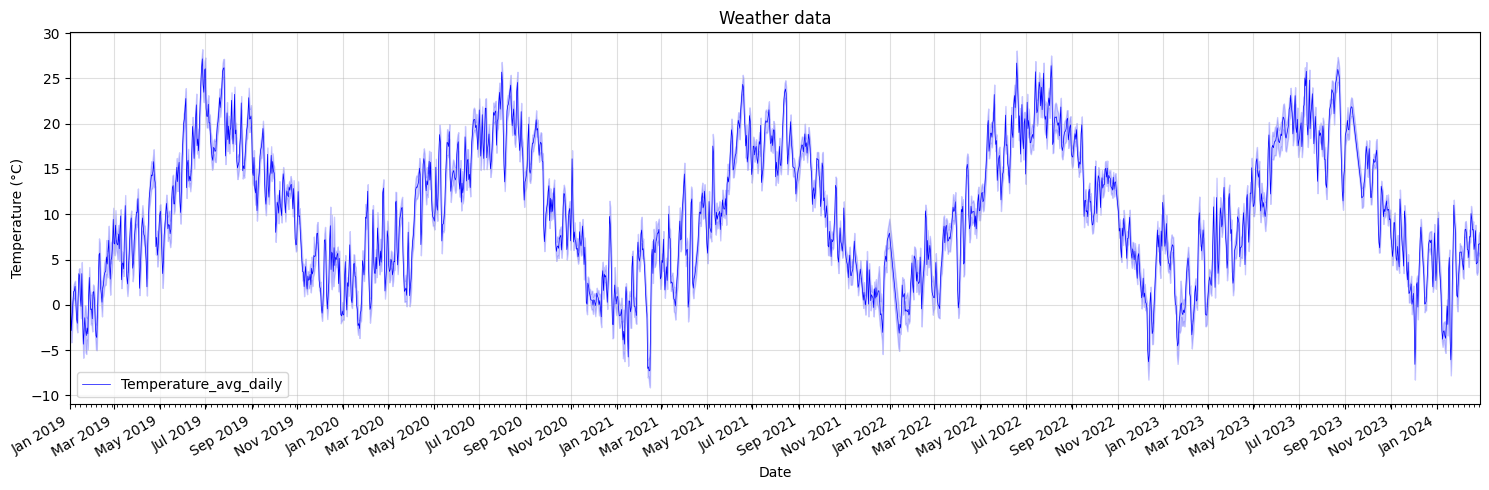

Temperature_max_daily : 1.3838796820878358 +- 0.46909730796014426
Temperature_min_daily : 1.278880588015534 +- 0.43354028886594287
Temperature_avg_daily : 1.0690030760096438 +- 0.31013704692182653


In [10]:
# get available weather IDs
weather_ids = heapo.get_weather_id_mapping()['Weather_ID'].unique()

# load all available weather data from the different stations and aggregate by timestamp
df_weather = heapo.load_weather_data_multiple(weather_ids, resolution='daily')[['Weather_ID', 'Timestamp', 'Temperature_max_daily', 'Temperature_min_daily', 'Temperature_avg_daily']]
df_weather.dropna(inplace=True)
df_weather = df_weather.groupby(['Timestamp']).agg(list).reset_index()

# only consider observations where all weather stations have data
df_weather['n'] = df_weather.apply(lambda row: len(row['Weather_ID']), axis=1)
df_weather = df_weather[df_weather['n'] == len(weather_ids)]
df_weather.drop(columns=['n'], inplace=True)
df_weather.sort_values('Timestamp', inplace=True)
df_weather.reset_index(drop=True, inplace=True)

# calculate mean and std for each day 
for col in ['Temperature_max_daily', 'Temperature_min_daily', 'Temperature_avg_daily']:
    df_weather[col+'_mean'] = df_weather[col].apply(lambda x: np.mean(x))
    df_weather[col+'_std'] = df_weather[col].apply(lambda x: np.std(x))
    df_weather[col+'_min'] = df_weather[col].apply(lambda x: np.min(x))
    df_weather[col+'_max'] = df_weather[col].apply(lambda x: np.max(x))

# exemplary plot
parameter = 'Temperature_avg_daily' # measured weather parameter to be plotted
color = 'blue' # color of the line
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df_weather.plot(ax=ax, x='Timestamp', y=parameter+'_mean', kind='line', linewidth=0.5, color=color, label=parameter)
ax.fill_between(df_weather['Timestamp'], df_weather[parameter+'_mean']-df_weather[parameter+'_std'], df_weather[parameter+'_mean']+df_weather[parameter+'_std'], color=color, alpha=0.2)
plt.title('Weather data')
ax.grid(alpha=0.4)
ax.set_xlim(df_weather['Timestamp'].min(), df_weather['Timestamp'].max())
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.tight_layout()
plt.show()

# calculate mean of the std for each parameter
for parameter in ['Temperature_max_daily', 'Temperature_min_daily', 'Temperature_avg_daily']:
    print(parameter, ':', df_weather[parameter+'_std'].mean(), '+-', df_weather[parameter+'_std'].std())

# display(df_weather)